In [1]:
import os
import pickle
from collections.abc import Callable
from pathlib import Path
from typing import Any

import cv2
import numpy as np
import torch
from torch import Tensor
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
from srcnn import SRCNN

In [3]:
class VideoFrameDataset(Dataset):
    def __init__(
        self, video_path: str, transform: Callable[[np.ndarray], Any] = None
    ) -> None:
        self.frames: list[np.ndarray] = []
        capture = cv2.VideoCapture(video_path)
        while True:
            success, frame = capture.read()
            if not success:
                break
            self.frames.append(frame)

        # Hack
        self.frames = self.frames[94:108]

        self.transform = transform

    def __len__(self) -> int:
        return len(self.frames)

    def __getitem__(self, index: int):
        frame = self.frames[index]
        if self.transform:
            frame = self.transform(frame)
        return frame

In [4]:
target_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((720, 1280)),
        v2.ToDtype(torch.float32, scale=False),
    ]
)

input_transform = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((240, 427)),
        v2.Resize((720, 1280)),
        v2.ToDtype(torch.float32, scale=False),
    ]
)


def transform(frame: np.ndarray) -> tuple[Tensor, Tensor]:
    return input_transform(frame), target_transform(frame)

In [5]:
video_path = os.fspath(Path.cwd().glob("*.mp4").__next__())
dataset = VideoFrameDataset(video_path, transform)
dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    pin_memory_device="cuda",
)

In [6]:
model_args = {
    "f1": 9,
    "f2": 1,
    "f3": 5,
    "n1": 64,
    "n2": 32,
    "qconfig": torch.ao.quantization.get_default_qat_qconfig("x86"),
}
device = "cuda"

In [7]:
model = SRCNN(**model_args).to(device)
optimizer = Adam(model.parameters(), lr=2e-4)

model.train()
epoch_losses = []
for epoch in range(1, 3000 + 1):
    # progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, quant=False)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        # progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best.pth")
        torch.save(model.state_dict(), "best.pth")

    epoch_losses.append(epoch_loss)

Epoch loss: 20056.544921875
Saving best.pth
Epoch loss: 18780.142578125
Saving best.pth
Epoch loss: 17762.85546875
Saving best.pth
Epoch loss: 16791.3828125
Saving best.pth
Epoch loss: 15940.2978515625
Saving best.pth
Epoch loss: 15189.6640625
Saving best.pth
Epoch loss: 14430.1953125
Saving best.pth
Epoch loss: 13656.0361328125
Saving best.pth
Epoch loss: 12864.681640625
Saving best.pth
Epoch loss: 12013.9873046875
Saving best.pth
Epoch loss: 11112.3515625
Saving best.pth
Epoch loss: 10181.337890625
Saving best.pth
Epoch loss: 9224.6474609375
Saving best.pth
Epoch loss: 8287.41796875
Saving best.pth
Epoch loss: 7363.09033203125
Saving best.pth
Epoch loss: 6450.94873046875
Saving best.pth
Epoch loss: 5569.86767578125
Saving best.pth
Epoch loss: 4736.9501953125
Saving best.pth
Epoch loss: 3967.8544921875
Saving best.pth
Epoch loss: 3282.025146484375
Saving best.pth
Epoch loss: 2697.9365234375
Saving best.pth
Epoch loss: 2232.96435546875
Saving best.pth
Epoch loss: 1894.7469482421875
Sav

Text(0, 0.5, 'Loss')

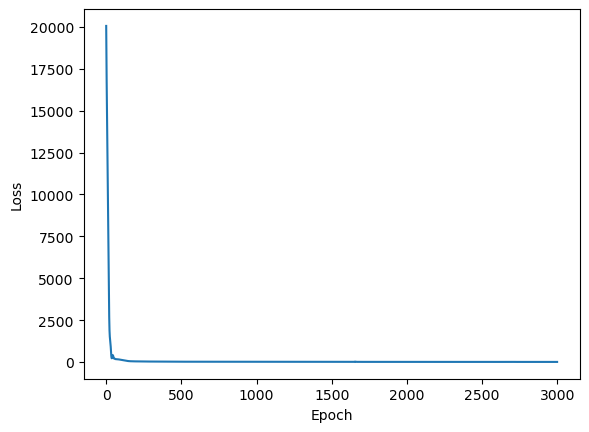

In [8]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [9]:
model = SRCNN(**model_args).to(device)
model.load_state_dict(torch.load("best.pth"))
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)

optimizer = Adam(model_qat.parameters(), lr=4e-5)

epoch_losses = []
for epoch in range(1, 1500 + 1):
    # progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    batch_losses = []

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_qat(inputs, quant=True)
        loss = F.mse_loss(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)
        # progress_bar.set_postfix(batch_loss=batch_loss)

    epoch_loss = np.mean(batch_losses)
    print(f"Epoch loss: {epoch_loss}")

    if len(epoch_losses) == 0 or epoch_loss < min(epoch_losses):
        print("Saving best_qat.pth")
        torch.save(model_qat.state_dict(), "best_qat.pth")

    epoch_losses.append(epoch_loss)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear once per process. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/aten/src/ATen/native/ReduceAllOps.cpp:72.)
  return torch.fused_moving_avg_obs_fake_quant(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/fake_quantize.py:353: UserWarning: _aminmax is deprecated as of PyTorch 1.11 and will be removed in a future release. Use aminmax instead. This warning will only appear

Epoch loss: 29.2609920501709
Saving best_qat.pth
Epoch loss: 38.04218292236328
Epoch loss: 26.370153427124023
Saving best_qat.pth
Epoch loss: 30.97273826599121
Epoch loss: 29.907236099243164
Epoch loss: 25.78467559814453
Saving best_qat.pth
Epoch loss: 29.244199752807617
Epoch loss: 30.03221893310547
Epoch loss: 26.786354064941406
Epoch loss: 26.695531845092773
Epoch loss: 27.403793334960938
Epoch loss: 28.1821346282959
Epoch loss: 27.81040382385254
Epoch loss: 27.153493881225586
Epoch loss: 26.24880027770996
Epoch loss: 26.369461059570312
Epoch loss: 25.62550163269043
Saving best_qat.pth
Epoch loss: 25.569839477539062
Saving best_qat.pth
Epoch loss: 25.27329444885254
Saving best_qat.pth
Epoch loss: 27.631074905395508
Epoch loss: 27.588655471801758
Epoch loss: 25.176753997802734
Saving best_qat.pth
Epoch loss: 24.627397537231445
Saving best_qat.pth
Epoch loss: 23.350069046020508
Saving best_qat.pth
Epoch loss: 23.946624755859375
Epoch loss: 26.44300079345703
Epoch loss: 26.183803558349

Text(0, 0.5, 'Loss')

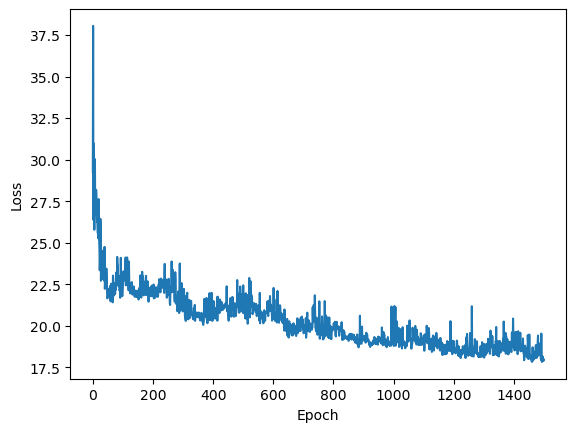

In [10]:
plt.plot(epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [11]:
model = SRCNN(**model_args).to(device)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.load_state_dict(torch.load("best_qat.pth"))
model_qat.cpu()
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
torch.save(model_converted.state_dict(), "converted.pth")

In [12]:
def show_image(image: np.ndarray | Tensor) -> None:
    if isinstance(image, Tensor):
        image = image.cpu().detach().numpy()
    if image.shape[0] == 1:
        image = image.squeeze(0)
    if image.shape[0] == 3:
        image = image.transpose((1, 2, 0))
    image = image.clip(0, 255).astype(np.uint8)
    plt.axis("off")
    plt.imshow(image)

/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/ao/quantization/utils.py:339: UserWarning: must run observer before calling calculate_qparams. Returning default values.
  warnings.warn(
/home/yunhao/miniforge3/envs/ece532-srcnn/lib/python3.11/site-packages/torch/_utils.py:404: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  device=storage.device,


Text(0.5, 1.0, 'Target')

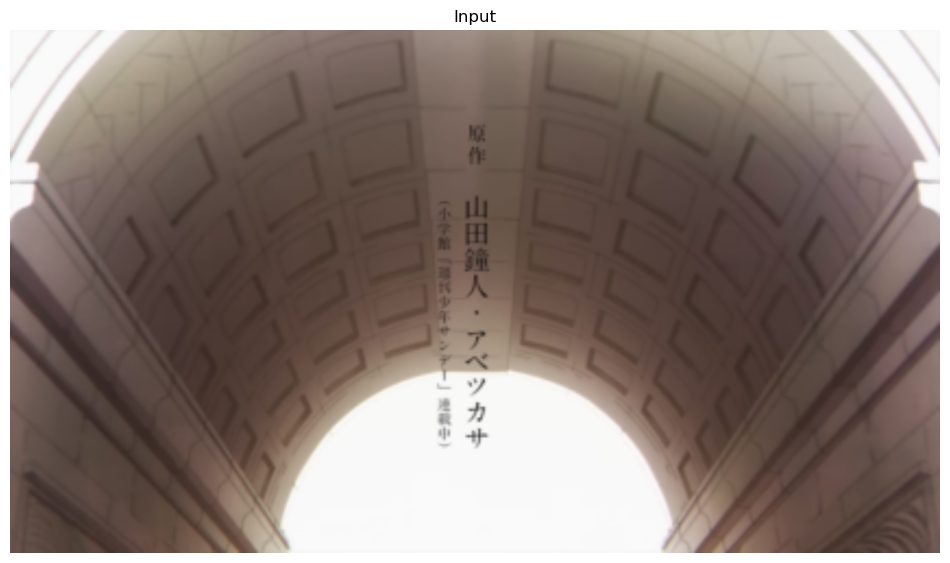

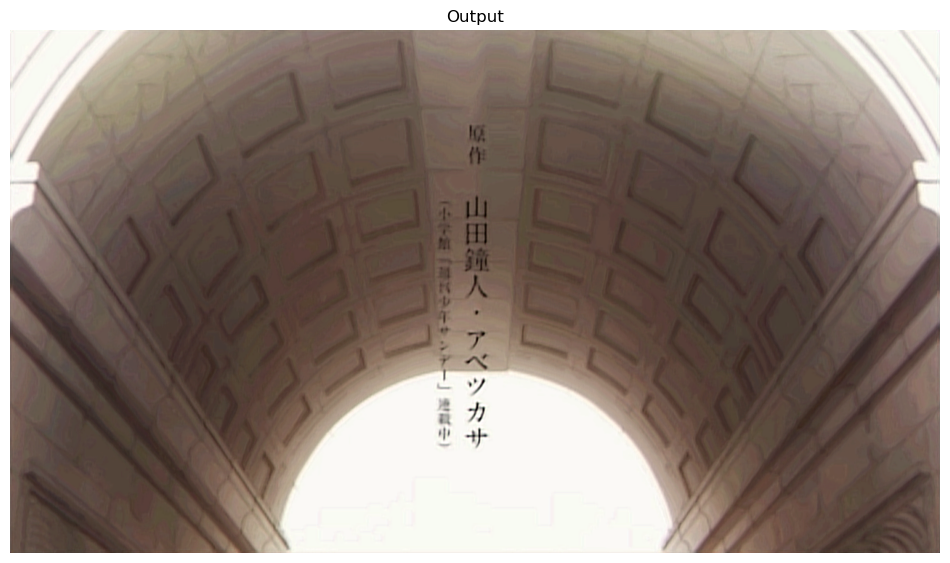

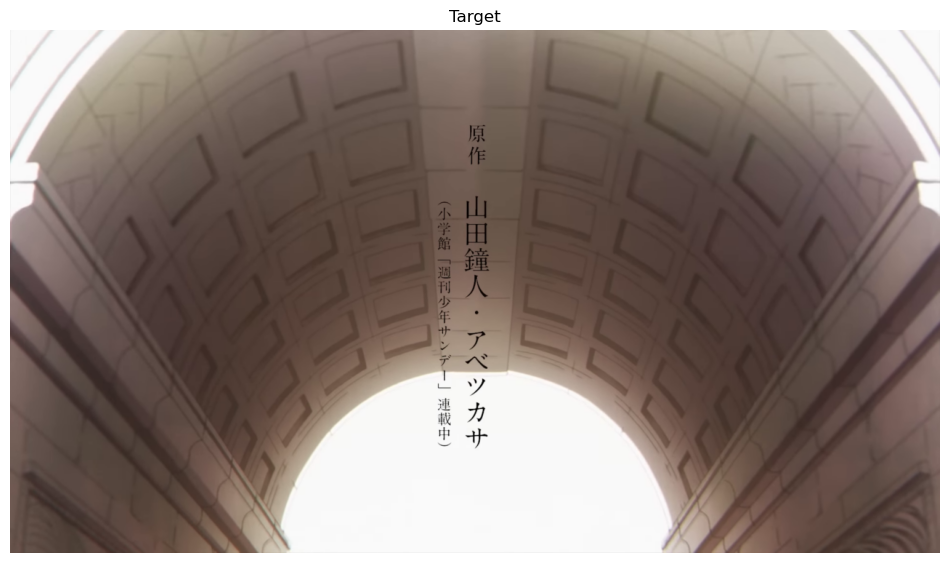

In [13]:
model = SRCNN(**model_args)
model.train()
model_qat = torch.ao.quantization.prepare_qat(model)
model_qat.eval()
model_converted = torch.ao.quantization.convert(model_qat)
model_converted.load_state_dict(torch.load("converted.pth"))

test_input, test_target = dataset[8]
test_input = test_input.unsqueeze(0)
test_output = model_converted(test_input, quant=True)

FIGURE_SIZE = (12, 8)

plt.figure(figsize=FIGURE_SIZE)
show_image(test_input)
plt.title("Input")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_output)
plt.title("Output")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_target)
plt.title("Target")

In [22]:
s = [30, 22, 23]

u = []
v = []
weights = []

x_scale_keys = ["quant.scale", "conv_layers.0.scale", "conv_layers.1.scale"]
x_zero_point_keys = [
    "quant.zero_point",
    "conv_layers.0.zero_point",
    "conv_layers.2.zero_point",
]

for i in range(3):
    conv_layers_weight = model_converted.state_dict()[f"conv_layers.{i}.weight"]
    bias = model_converted.state_dict()[f"conv_layers.{i}.bias"]

    x_scale = model_converted.state_dict()[x_scale_keys[i]]
    y_scale = model_converted.state_dict()[f"conv_layers.{i}.scale"]
    A_scale = conv_layers_weight.q_per_channel_scales()

    u.append(x_scale / y_scale * A_scale * (2 ** s[i]))
    v.append((bias / y_scale) * (2 ** s[i]))

    A_q = conv_layers_weight.int_repr()
    x_0 = model_converted.state_dict()[x_zero_point_keys[i]]

    weight = A_q * u[i].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    weights.append(weight)

weights[0] = weights[0] / model_converted.state_dict()["quant.scale"]
weights[2] = weights[2] * y_scale

Text(0.5, 1.0, 'Output')

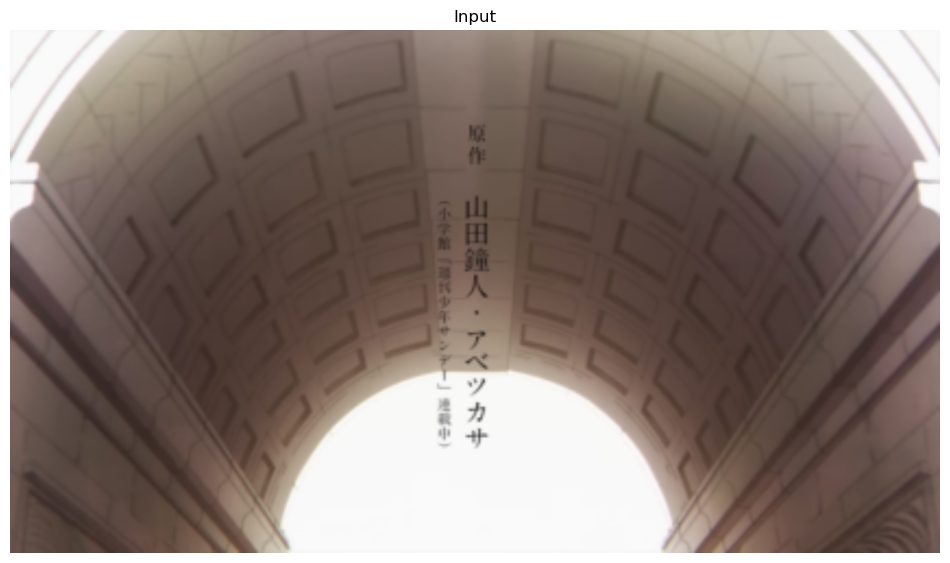

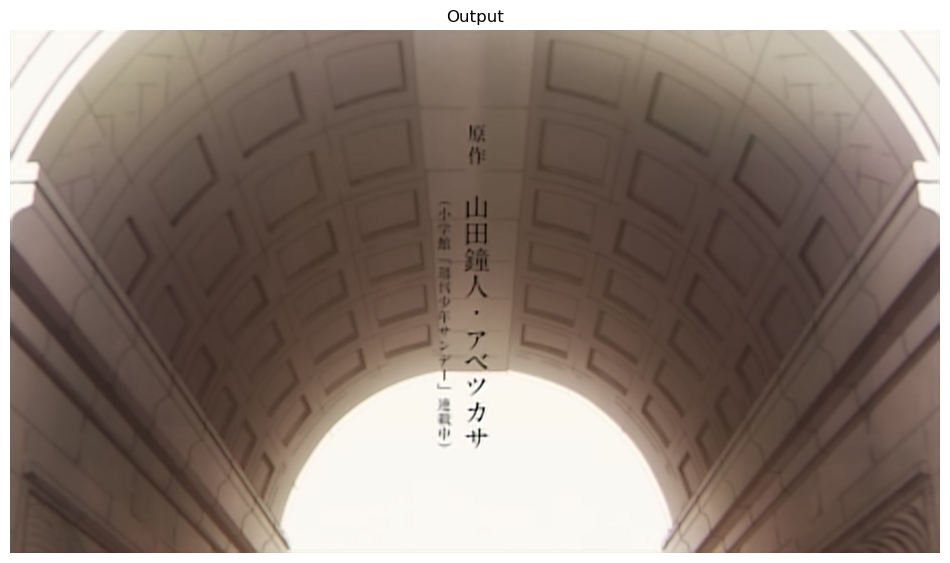

In [24]:
ACTIVATION_SHIFT = 6

ACTIVATION_WIDTH = 16
ACTIVATION_MIN = -(2 ** (ACTIVATION_WIDTH - 1))
ACTIVATION_MAX = 2 ** (ACTIVATION_WIDTH - 1) - 1

WEIGHT_WIDTH = 25
WEIGHT_MIN = -(2 ** (WEIGHT_WIDTH - 1))
WEIGHT_MAX = 2 ** (WEIGHT_WIDTH - 1) - 1

DSP_OUTPUT_WIDTH = 48
DSP_OUTPUT_MIN = -(2 ** (DSP_OUTPUT_WIDTH - 1))
DSP_OUTPUT_MAX = 2 ** (DSP_OUTPUT_WIDTH - 1) - 1

test_output = test_input.double() * (2**ACTIVATION_SHIFT)

for i, weight in enumerate(weights):
    assert weight.min() >= WEIGHT_MIN, f"Weight {i} min: {weight.min()}"
    assert weight.max() <= WEIGHT_MAX, f"Weight {i} max: {weight.max()}"

    test_output = (
        F.conv2d(
            test_output, weight.double().round(), v[i].double().round(), padding="same"
        )
        .double()
        .round()
    )
    assert test_output.min() >= DSP_OUTPUT_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= DSP_OUTPUT_MAX, f"Output {i} max: {test_output.max()}"

    test_output = F.relu(test_output * (2 ** -s[i])).double().floor()
    assert test_output.min() >= ACTIVATION_MIN, f"Output {i} min: {test_output.min()}"
    assert test_output.max() <= ACTIVATION_MAX, f"Output {i} max: {test_output.max()}"

test_output = (test_output * (2**-ACTIVATION_SHIFT)).double().floor()

plt.figure(figsize=FIGURE_SIZE)
show_image(test_input)
plt.title("Input")

plt.figure(figsize=FIGURE_SIZE)
show_image(test_output)
plt.title("Output")

In [25]:
with open("weights.pkl", "wb") as fp:
    pickle.dump(weights, fp)
with open("biases.pkl", "wb") as fp:
    pickle.dump(v, fp)